# Changes from v12_2
* Not using cTakes
* Evaluating different CPT code sets
* Cleaning up the folder and the data

# Notes

## Questions
* Run the data for each category with only no filter, one, and three CPT codes for each discharge summary
    * ANSWER: It performs better with only 1 CPT per note and 3 had a decrease of 3% in accuracy
* Does including all notes/CPT sections improve accuracy?
    * ANSWER: No, it decreased the accuracy
* Does including some sections improve accuracy when included with discharge summary?
    * No, accuracy went from 80% to 71%- at least for the E/M category
* Does accuracy improve when there are more notes per CPT code?
    * Yes
* What is the lowest threshold I can use without decreasing accuracy?
    * It seems like I don't need a threshold
* Does imbalance correction improve model accuracy?
    * Yes, it makes a huge difference
* Is undersampling or over-sampling a better method for imbalance correction?
    * Oversampling since the lowest records only contain one note - could also try SMOTE and see if that gives better results or not
* Use label encoder for the CPT codes
    * Does the accuracy improve when using labelencoder?
* Is limiting CPT codes to just one excluding CPT codes?
    * No
* What is the accuracy when filtered to each CPT section individually?

# Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gzip
import pandas as pd
import glob
import string
from sklearn.utils import resample
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report


# Import the MIMIC data

In [2]:
dataset_dictionary = {}

for file_path in glob.glob('.\\Data\\MIMIC Files\*'):
    file_name = file_path.split('\\')[3].split('.')[0]
    with gzip.open(file_path, mode='r') as file:
        dataset_dictionary[file_name] = pd.read_csv(file)

c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Assign Datatypes

In [6]:
# Check all the datasets exist in the dictionary 
print(dataset_dictionary.keys())

# Check the datatypes and information for each table 
for i in dataset_dictionary.keys():
    print(dataset_dictionary[i].info())

# Correct any datatype issues #####

# CPTEVENTS
dataset_dictionary['CPTEVENTS'].loc[:,['SECTIONHEADER','CPT_CD']] = dataset_dictionary['CPTEVENTS'].loc[:,['SECTIONHEADER','CPT_CD']].astype(str)
dataset_dictionary['CPTEVENTS']['CHARTDATE'] = dataset_dictionary['CPTEVENTS']['CHARTDATE'].to_datetime()

dict_keys(['CPTEVENTS', 'DIAGNOSES_ICD', 'D_CPT', 'D_ICD_DIAGNOSES', 'D_ICD_PROCEDURES', 'NOTEEVENTS', 'PATIENTS', 'PROCEDURES_ICD'])
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573146 entries, 0 to 573145
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ROW_ID            573146 non-null  int64  
 1   SUBJECT_ID        573146 non-null  int64  
 2   HADM_ID           573146 non-null  int64  
 3   COSTCENTER        573146 non-null  object 
 4   CHARTDATE         101545 non-null  object 
 5   CPT_CD            573146 non-null  object 
 6   CPT_NUMBER        573128 non-null  float64
 7   CPT_SUFFIX        22 non-null      object 
 8   TICKET_ID_SEQ     471601 non-null  float64
 9   SECTIONHEADER     573146 non-null  object 
 10  SUBSECTIONHEADER  573125 non-null  object 
 11  DESCRIPTION       101545 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 52.5+ MB
None
<class 'pandas.

AttributeError: 'Series' object has no attribute 'to_datetime'

# Exploratory Data Analysis - CPTEVENTS Table


Total CPT counts per section

 SECTIONHEADER
Anesthesia                      687
Emerging technology              22
Evaluation and management    404388
Medicine                     114194
Pathology and laboratory         53
Radiology                      2974
Surgery                       50807
nan                              21
Name: CPT_CD, dtype: int64

Total Unique CPT counts per section

 SECTIONHEADER
Anesthesia                      5
Emerging technology             8
Evaluation and management      58
Medicine                       91
Pathology and laboratory        4
Radiology                      61
Surgery                      1784
nan                             7
Name: CPT_CD, dtype: int64

 Section Header: Anesthesia 

count      5.000000
mean     137.400000
std      243.206291
min        2.000000
25%       21.000000
50%       37.000000
75%       56.000000
max      571.000000
Name: CPT_CD, dtype: float64

 Section Header: Emerging technology 

count    8.00000
mean     2

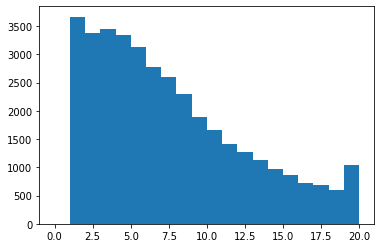

In [79]:
# How many CPT codes are in the data for each CPT section? -----
data_cpt = dataset_dictionary['CPTEVENTS']
print('\nTotal CPT counts per section\n\n', data_cpt.groupby('SECTIONHEADER')['CPT_CD'].count())

# How many unique CPT codes are there per CPT section? -----
data_nodups = data_cpt.loc[:,['CPT_CD', 'SECTIONHEADER']].drop_duplicates()
print('\nTotal Unique CPT counts per section\n\n', data_nodups.groupby('SECTIONHEADER')['CPT_CD'].count())

# What is the distribution of counts for each CPT code per section? -----
for i in np.unique(data_cpt['SECTIONHEADER']):
    print('\n Section Header:',i,'\n')
    print(data_cpt[data_cpt['SECTIONHEADER'] == i].groupby('CPT_CD')['CPT_CD'].count().describe())
    
# How many unique CPT codes are there per CPT section when filtered to the Discharge Summary Section in the Note Events Table? -----
data_notes = dataset_dictionary['NOTEEVENTS']
data_notes = data_notes[data_notes['CATEGORY'] == 'Discharge summary']
data_merged = data_notes.merge(data_cpt, on = ['SUBJECT_ID','HADM_ID'])
data_nodups = data_merged.loc[:,['CPT_CD', 'SECTIONHEADER']].drop_duplicates()
print('\nTotal Unique CPT counts per section\n\n', data_nodups.groupby('SECTIONHEADER')['CPT_CD'].count())

# Are there multiple CPT codes per encounter? -----
# Answer: Yes

data_cpt.groupby('HADM_ID')['CPT_CD'].count()

# What percentage of encounters only have one CPT code?
# Answer: 8.3%
data_grouped = data_cpt.groupby('HADM_ID')['CPT_CD'].count()
(data_grouped == 1).sum()/ len(np.unique(data_cpt['HADM_ID']))

# What does the distribution look like for number of CPT codes per encounter?
data_grouped = data_cpt.groupby('HADM_ID')['CPT_CD'].count()
plt.hist(data_grouped, bins=range(21))
plt.show()

# Exploratory Data Analysis - NOTEEVENTS Table

In [103]:
data = dataset_dictionary['NOTEEVENTS']

# What are the unique categories?
print(np.unique(data['CATEGORY']))

# What do some of the notes look like in each category?
print(data[data['CATEGORY'] == 'Physician ']['TEXT'].iloc[0])

# How many notes are there per category?
data.groupby('CATEGORY')['CATEGORY'].count()


['Case Management ' 'Consult' 'Discharge summary' 'ECG' 'Echo' 'General'
 'Nursing' 'Nursing/other' 'Nutrition' 'Pharmacy' 'Physician ' 'Radiology'
 'Rehab Services' 'Respiratory ' 'Social Work']
Chief Complaint:
   24 Hour Events:
 Continued to be anuric.  Tolerated HD well.  Decision today by pt and
   wife to convert to [**Name (NI) 617**].
   History obtained from Patient
   Allergies:
   History obtained from PatientHeparin Agents
   Thrombocytopeni
   Last dose of Antibiotics:
   Piperacillin - [**2138-3-20**] 08:00 PM
   Piperacillin/Tazobactam (Zosyn) - [**2138-3-21**] 09:00 AM
   Metronidazole - [**2138-3-21**] 10:12 AM
   Infusions:
   Other ICU medications:
   Other medications:
   Changes to medical and family history:
   Review of systems is unchanged from admission except as noted below
   Review of systems:
   Flowsheet Data as of  [**2138-3-21**] 02:56 PM
   Vital signs
   Hemodynamic monitoring
   Fluid balance
                                                          

CATEGORY
Case Management         967
Consult                  98
Discharge summary     59652
ECG                  209051
Echo                  45794
General                8301
Nursing              223556
Nursing/other        822497
Nutrition              9418
Pharmacy                103
Physician            141624
Radiology            522279
Rehab Services         5431
Respiratory           31739
Social Work            2670
Name: CATEGORY, dtype: int64

# Exploratory Data Analysis - Other

In [258]:
# If I filter to just one CPT code per encounter, am I excluding some CPT codes that always appear with other CPT codes?

def filter_df(combined_df, threshold):

    # Print value counts original
    print('Value Counts for the original data:\n\n', combined_df['CPT_CD'].value_counts().head(25))

    # Filter based on count limit
    df = combined_df['CPT_CD'].value_counts()
    filtered_ls = list((df[df >= threshold]).index.values)
    filtered_df = combined_df[combined_df['CPT_CD'].isin(filtered_ls)]
    
    # Print value counts filtered
    print('Value Counts for the filtered data:\n\n', filtered_df['CPT_CD'].value_counts().head(25))

    return filtered_df

x = filter_df(note_cpt, 1)

# There are no CPT codes that are being excluded from the filter
set(note_cpt['CPT_CD']) - set(x['CPT_CD'])

Value Counts for the original data:

 99291    25967
99232    23987
99233    22791
94003    16395
99231    12441
94002    11130
99223     9271
99239     8775
99254     7896
99222     6846
99238     6342
99255     5512
99253     5377
99292     3864
36556     3490
99252     2194
90935     1846
33508     1763
33533     1719
36620     1597
99221     1574
31624     1317
31645     1275
31622     1005
76937      918
Name: CPT_CD, dtype: int64
Value Counts for the filtered data:

 99291    25967
99232    23987
99233    22791
94003    16395
99231    12441
94002    11130
99223     9271
99239     8775
99254     7896
99222     6846
99238     6342
99255     5512
99253     5377
99292     3864
36556     3490
99252     2194
90935     1846
33508     1763
33533     1719
36620     1597
99221     1574
31624     1317
31645     1275
31622     1005
76937      918
Name: CPT_CD, dtype: int64


set()

# Join the tables

In [8]:
def join_tables(dataset_dictionary, category=['Discharge summary'], all_notes=False):

    # Define tables
    note_events_base = dataset_dictionary['NOTEEVENTS']
    cpt_events_base = dataset_dictionary['CPTEVENTS']
    
    # Combine text for each subject and encounter
    if all_notes == False:
        note_events_base = note_events_base[note_events_base.loc[:,'CATEGORY'].isin(category)]

    note_events = note_events_base.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False)['TEXT'].agg(sum)

    # Create CPT table
    cpt_events_base = cpt_events_base.loc[:, ['SUBJECT_ID','HADM_ID', 'CPT_CD']]
    cpt_events = cpt_events_base.drop_duplicates()
    
    # Join the datasets
    note_cpt = note_events.merge(cpt_events, on = ['SUBJECT_ID','HADM_ID'])
    
    return note_cpt
    
note_cpt = join_tables(dataset_dictionary)
# ['Consult','Discharge summary','General', 'Nursing', 'Nursing/other'\
#                                             , 'Physician ','Rehab Services','Respiratory ']

In [32]:
note_cpt['CPT_CD'].value_counts().head(50)

99291    25967
99232    23987
99233    22791
94003    16395
99231    12441
94002    11130
99223     9271
99239     8775
99254     7896
99222     6846
99238     6342
99255     5512
99253     5377
99292     3864
36556     3490
99252     2194
90935     1846
33508     1763
33533     1719
36620     1597
99221     1574
31624     1317
31645     1275
31622     1005
76937      918
31600      898
33405      808
31500      786
76942      784
99251      771
90945      688
33518      663
43246      582
99262      575
33519      573
99356      533
99261      466
62270      408
69990      397
31646      392
90937      381
90801      365
93503      331
32002      274
32551      273
99263      268
33517      259
36489      236
61510      226
49080      224
Name: CPT_CD, dtype: int64

# Filter the data

In [24]:
def filter_df(combined_df, threshold):

    # Print value counts original
    print('Value Counts for the original data:\n\n', combined_df['CPT_CD'].value_counts().head(25))

    # Filter based on count limit
    df = combined_df['CPT_CD'].value_counts()
    filtered_ls = list((df[df >= threshold]).index.values)
    filtered_df = combined_df[combined_df['CPT_CD'].isin(filtered_ls)]
    
    # Print value counts filtered
    print('Value Counts for the filtered data:\n\n', filtered_df['CPT_CD'].value_counts().head(25))

    return filtered_df

# Find Counts of CPT Codes per Patient Encounter and filter df #####
def cpt_count_filter(df, og_df, limit):

    og_df = og_df.groupby('HADM_ID')['CPT_CD'].count()
    filtered_encntrs = og_df[og_df <= limit]
    final_df = df.merge(filtered_encntrs, on='HADM_ID')
    final_df.drop('CPT_CD_y', axis=1, inplace=True)
    final_df.columns = ['SUBJECT_ID', 'HADM_ID', 'TEXT', 'CPT_CD']
    
    print('Value Counts for the filtered data:\n\n', final_df['CPT_CD'].value_counts().head(25))

    return final_df

filtered_df = cpt_count_filter(note_cpt, note_cpt, 1)
# filtered_df = filter_df(filtered_df, 10)

Value Counts for the filtered data:

 94003    1359
94002     672
99291     553
99254     184
99253     159
99222     131
99223     123
99232     108
99255     105
99233      98
54150      84
99238      69
99252      55
99231      50
33405      48
99221      43
99251      24
33427      21
99239      20
36556      19
33430       9
33641       8
99220       7
99235       7
99236       7
Name: CPT_CD, dtype: int64


# Clean the data

In [10]:
def clean_data(text_series):
    
    # Replace \n 
    text_series = text_series.str.replace('\\n',' ', regex=True)    

    # Remove dates and locations
    text_series = text_series.str.replace('\[\*\*(.*?)\*\*\]', ' ', regex=True)
    
    # Remove topics
    data = text_series.str.split('([A-Z\s]+:)')
    for row_num, value in enumerate(data):
        text_chunks = [x.strip().replace(':','').replace('\n', '') for x in value]
        for i, x in enumerate(text_chunks):
            if 'MEDICATION' in x or 'SOCIAL HISTORY' in x or 'FAMILY HISTORY' in x:
                text_chunks[i] = ' '
                try:
                    text_chunks[i + 1] = ' '
                except:
                    continue

        text_series.iloc[row_num] = ' '.join(text_chunks)
    
    # Replace punctuation
    text_series = text_series.str.replace('[' + string.punctuation + ']', ' ', regex=True)
    
    # Convert to lowercase 
    text_series = text_series.str.lower()
    
    # Remove all digits
    text_series = text_series.str.replace('\d',' ', regex=True)
    
    # Replace plurals, endings with ing, endings with ed, endings with ly
#     text_series = text_series.str.replace('s(?=\s)', ' ', regex=True)
#     text_series = text_series.str.replace('ing(?=\s)', ' ', regex=True)
#     text_series = text_series.str.replace('ed(?=\s)', ' ', regex=True)
#     text_series = text_series.str.replace('ly(?=\s)', ' ', regex=True)
    
    return text_series

# Update Text Column -----
filtered_df.loc[:, 'TEXT'] = clean_data(filtered_df['TEXT']).values

# Balance the data

In [11]:
def oversample_df(filtered_df):
    
    # Check counts
    df_cts = filtered_df['CPT_CD'].value_counts()

    # Remove CPT with largest count
    df = list(df_cts.index.values)
    most_freq_cpt = df[0]
    df.remove(most_freq_cpt)

    # Resample
    minority_df = []
    for i in df:
        test_resampled = resample(filtered_df[filtered_df['CPT_CD'] == i], replace=True, n_samples=max(df_cts), random_state=123)
        minority_df.append(test_resampled)
    
    # Add back largest group and create final dataframe
    minority_df.append(filtered_df[filtered_df['CPT_CD'] == most_freq_cpt])
    new_df = pd.concat(minority_df)
    new_df['CPT_CD'] = new_df['CPT_CD']
    
    return new_df

filtered_df = oversample_df(filtered_df)

# Check for Imbalance

In [243]:
filtered_df['CPT_CD'].value_counts()

63276    1359
21627    1359
33877    1359
99253    1359
32602    1359
         ... 
33427    1359
58720    1359
99291    1359
33533    1359
48140    1359
Name: CPT_CD, Length: 134, dtype: int64

# Label Encode the Predictors

In [249]:
le = preprocessing.LabelEncoder()
filtered_df['CPT_CD'] = le.fit_transform(filtered_df['CPT_CD'])

# Check the CPT code counts

In [14]:
filtered_df['CPT_CD'].value_counts()

33416    1359
62140    1359
44850    1359
61697    1359
99261    1359
         ... 
61154    1359
99231    1359
99233    1359
99253    1359
58720    1359
Name: CPT_CD, Length: 134, dtype: int64

In [23]:
note_cpt['CPT_CD'].value_counts().head(50)

99291    25967
99232    23987
99233    22791
94003    16395
99231    12441
94002    11130
99223     9271
99239     8775
99254     7896
99222     6846
99238     6342
99255     5512
99253     5377
99292     3864
36556     3490
99252     2194
90935     1846
33508     1763
33533     1719
36620     1597
99221     1574
31624     1317
31645     1275
31622     1005
76937      918
31600      898
33405      808
31500      786
76942      784
99251      771
90945      688
33518      663
43246      582
99262      575
33519      573
99356      533
99261      466
62270      408
69990      397
31646      392
90937      381
90801      365
93503      331
32002      274
32551      273
99263      268
33517      259
36489      236
61510      226
49080      224
Name: CPT_CD, dtype: int64

# Split the Data

In [15]:
# List stop words
my_stop_words = list(set(stopwords.words('english'))) \
                + ['admission', 'date', 'sex'] \
                + ['needed', 'every', 'seen', 'weeks', 'please', 'ml', 'unit', 'small', 'year', 'old', 'cm', 'non', 'mm', 'however']
                # Got the above from my top 100 most predictive words that I wanted to remove

# Split the data so number of CPT Codes per record = 1
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(filtered_df['TEXT'].values, filtered_df['CPT_CD'], range(len(filtered_df['CPT_CD'])), test_size = .1, random_state = 42, shuffle=True)


# Tokenize the data

In [16]:
# Import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=my_stop_words)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

# Run Naive Bayes

In [17]:
# Use Naive Bayes model
nb_classifier = MultinomialNB(alpha=.7)

# Fit and check accuracy
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)

# Evaluation

In [18]:
# Check accuracy
print(metrics.accuracy_score(y_test, pred))

"""
Checks on counts of CPT code per encounter
-----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: 200
Category/Categories: Discharge Summary

No constraints on CPT codes per encounter: 0.5082697201017812
One CPT code per encounter: 0.5510543263737405
Three CPT codes or less per encounter: 0.52065226388544

Results: Looks like the accuracy is improved quite a bit when using just one CPT per encounter. The downside is less data
-----------------------------------------

#####

Checks on using all notes vs. only the discharge summary section
-----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: 200
Number of CPT's per record: unrestricted

Discharge Summary: .50
All notes: 0.48813608819449517

Results: Using all notes lead to a decreased accuracy
-----------------------------------------

#####

Using ['Consult','Discharge summary','General', 'Nursing', 'Nursing/other', 'Physician ','Rehab Services','Respiratory ']
categories instead of just discharge summary
-----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: 200
Number of CPT's per record: 1

Discharge Summary: .799
Selected Categories: 0.7163814180929096

Results: Using more notes decreased the score
----------------------------------------

##### 

What effect does decreasing the note sample size have on accuracy?
----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: 50
Number of CPT's per record: 1

Discharge Summary w/200 notes per CPT: .799
Discharge Summary w/50 notes per CPT: 0.7609038360483448
Discharge Summary w/40 notes per CPT: 0.7788505747126436
Discharge Summary w/20 notes per CPT: 0.8029423151374371
Discharge Summary w/10 notes per CPT: 0.8027961736571008
Discharge Summary - no threshold for notes per CPT: 0.9673274394596673

Results: It looks like a note restriction is unnecessary
----------------------------------------

#####

Does balancing the data improve the model's accuracy?
----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: no-restriction
Number of CPT's per record: 1

Accuracy without balancing: 0.344578313253012
Accuracy with balancing: 0.9673274394596673

Results: It definitely helps

#####

Does using label encoding affect accuracy?
----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: no-restriction
Number of CPT's per record: 1

Accuracy without labelencoding: 0.9673274394596673
Accuracy with labelencoding: 0.9673274394596673

Results: No, but it is still a good idea since they are deprecating the ability to have strings as predictors
"""



0.9657349953324913


"\nChecks on counts of CPT code per encounter\n-----------------------------------------\nTest size: .1\nRandom Number: 42\n# of records per CPT: 200\nCategory/Categories: Discharge Summary\n\nNo constraints on CPT codes per encounter: 0.5082697201017812\nOne CPT code per encounter: 0.5510543263737405\nThree CPT codes or less per encounter: 0.52065226388544\n\nResults: Looks like the accuracy is improved quite a bit when using just one CPT per encounter. The downside is less data\n-----------------------------------------\n\n#####\n\nChecks on using all notes vs. only the discharge summary section\n-----------------------------------------\nTest size: .1\nRandom Number: 42\n# of records per CPT: 200\nNumber of CPT's per record: unrestricted\n\nDischarge Summary: .50\nAll notes: 0.48813608819449517\n\nResults: Using all notes lead to a decreased accuracy\n-----------------------------------------\n\n#####\n\nUsing ['Consult','Discharge summary','General', 'Nursing', 'Nursing/other', 'Ph

# Classification Report

In [19]:
# Create classification report taken from here: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
print('Test')
class_labels = nb_classifier.classes_
print(classification_report(y_test, pred))

print('Training')
pred_x = nb_classifier.predict(tfidf_train)
print(classification_report(y_train, pred_x))

# Counts by number of CPT values in test
print(y_test.value_counts())

Test
              precision    recall  f1-score   support

       01996       1.00      1.00      1.00       140
       19260       1.00      1.00      1.00       122
       19303       0.97      1.00      0.98       121
       21627       1.00      1.00      1.00       147
       24505       1.00      1.00      1.00       130
       27033       1.00      1.00      1.00       123
       27130       0.96      1.00      0.98       154
       27226       1.00      1.00      1.00       158
       27228       1.00      1.00      1.00       153
       27236       1.00      1.00      1.00       146
       27245       1.00      1.00      1.00       130
       27447       1.00      1.00      1.00       135
       27506       1.00      1.00      1.00       136
       27511       1.00      1.00      1.00       139
       27814       1.00      1.00      1.00       126
       27880       1.00      1.00      1.00       114
       31500       1.00      1.00      1.00       131
       31622       0.9

In [7]:
import numpy as np
print(np.percentile([1,2,3,54],97.5))
# ?np.percentile

from sklearn.utils import resample

# resample([1,2,3,54], replace=True, n_samples=4, random_state=123)

50.17499999999999
